> First we work with a samlpe of our data and devise the basic workflow => go to scripting and iterate (caching important) while tracking runs

In [1]:
import mlflow

import xgboost as xgb
import pandas as pd
import seaborn as sns
import dask.dataframe as dd # modin would be a good drop-in replacement


from xgboost.dask import DaskXGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

/home/koowah/miniconda3/envs/newmlops/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---

# Data Loading

In [2]:
data_path = "../data/raw/train.csv"
df = pd.read_csv(data_path, index_col=0)

In [3]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


---

# Cleaning

In [4]:
df.shape

(1460, 80)

In [5]:
df.isna().sum().sort_values(ascending=False).head(15)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
dtype: int64

In [6]:
columns_to_drop = df.isna().sum().sort_values(ascending=False)[:7].index.tolist()

In [7]:
df = df.drop(columns=columns_to_drop)

In [8]:
garage_columns = [col for col in df.columns if "garage" in col.lower()]
df[garage_columns] = df[garage_columns].fillna("0")

In [9]:
df.isna().sum().sort_values(ascending=False).head(10)

BsmtFinType2    38
BsmtExposure    38
BsmtFinType1    37
BsmtQual        37
BsmtCond        37
MasVnrArea       8
Electrical       1
MSSubClass       0
Functional       0
TotRmsAbvGrd     0
dtype: int64

In [10]:
bsmt_columns = [col for col in df.columns if "bsmt" in col.lower()]
df[bsmt_columns] = df[bsmt_columns].fillna("0")

In [11]:
df = df.dropna()

In [12]:
df.GarageYrBlt = df.GarageYrBlt.astype('int64')

---

# Data Splits

In [13]:
target = "SalePrice"
data = df.copy()
y = data.pop(target)
X = data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<Axes: xlabel='SalePrice', ylabel='Count'>

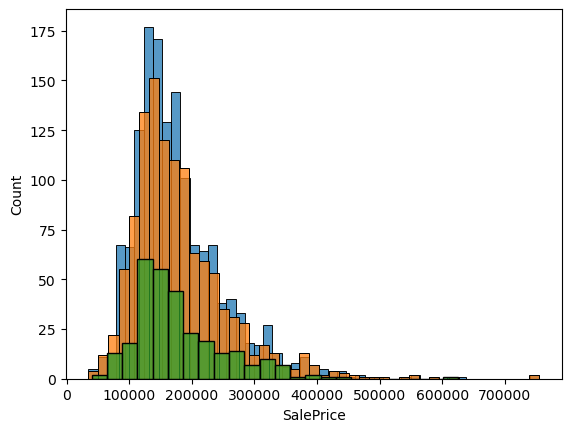

In [15]:
sns.histplot(df.SalePrice)
sns.histplot(y_train)
sns.histplot(y_test)

--- 

# Preprocessing

- Tree-based model => label encoding (no need one hot)

In [16]:
from sklearn.preprocessing import OrdinalEncoder

In [17]:
class MultiColumnLabelEncoder:
    def __init__(self) -> None:
        pass
    
    def fit(self, df:pd.DataFrame) -> None:
        categorical_columns = df.select_dtypes("object").columns
        encoders = {col:OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1) for col in categorical_columns}
        
        self.fitted_columns = categorical_columns.tolist()
        self.encoders = encoders
        for col in categorical_columns:
            self.encoders[col].fit(df[[col]])
    
    def transform(self, df:pd.DataFrame) -> pd.DataFrame:
        df_copy = df.copy()
        categorical_columns = df_copy.select_dtypes("object").columns
        # error handling
        for col in categorical_columns:
            df_copy[col] = self.encoders[col].transform(df_copy[[col]])
        return df_copy
    
    def fit_transform(self, df):
        self.fit(df)
        df_copy = self.transform(df)
        return df_copy
    
    def inverse_transform(self, df):
        df_copy = df.copy()
        relevant_columns = df_copy.columns.intersection(self.fitted_columns)
        for col in relevant_columns:
            df_copy[col] = self.encoders[col].inverse_transform(df_copy[[col]]).flatten()
        return df_copy

In [18]:
def preprocess(df):
    df_copy = df.copy()
    label_encoder = MultiColumnLabelEncoder()
    preprocessed_df = label_encoder.fit_transform(df_copy)
    return preprocessed_df, label_encoder

In [19]:
# encoded_df, label_encoder = preprocess(X_train)
# decoded_df = label_encoder.inverse_transform(encoded_df)

--- 

# Training

In [20]:
X_train_processed, _ = preprocess(X_train)

In [21]:
model = xgb.XGBRegressor(objective="reg:squarederror")

In [22]:
_ = model.fit(X_train_processed, y_train)

--- 

# Evaluation

In [23]:
predictions = model.predict(preprocess(X_test)[0])

In [24]:
loss = mean_squared_error(y_test, predictions)

In [25]:
loss

506955645.9616492

In [26]:
mae, mape = mean_absolute_error(y_test, predictions), mean_absolute_percentage_error(y_test, predictions)

---

# Exp Tracking

In [27]:
from pathlib import Path
from datetime import date

In [28]:
MODEL_REGISTRY = Path("../models/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = MODEL_REGISTRY.absolute().as_uri()
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

experiment_name = f"xgb_housing_{date.today()}"
mlflow.set_experiment(experiment_name)

2024/05/23 20:42:20 INFO mlflow.tracking.fluent: Experiment with name 'xgb_housing_2024-05-23' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/koowah/codeland/mlops_eos_project/notebooks/../models/mlflow/706764080212434757', creation_time=1716489740779, experiment_id='706764080212434757', last_update_time=1716489740779, lifecycle_stage='active', name='xgb_housing_2024-05-23', tags={}>

In [29]:
with mlflow.start_run():
    mlflow.log_params(model.get_params())
    mlflow.log_param("features", ",".join(X_train.columns.tolist()))
    
    model_info = mlflow.xgboost.log_model(
        model, "xgb", 
        
    )
    mlflow.log_metrics({"mse":loss, "mae":mae, "mape":mape})

/home/koowah/miniconda3/envs/newmlops/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:42:20] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


---

# HP-tuning

In [30]:
import optuna
import math

In [31]:
def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [32]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            'objective':trial.suggest_categorical("objective", ["reg:squarederror", "reg:squaredlogerror"]),
            "max_depth":trial.suggest_int('max_depth', 3, 9),
            "gamma":trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            "eta":trial.suggest_float('eta', 0.01, 0.3, log=True),
            "reg_alpha":trial.suggest_float('alpha', 1e-8, 1.0, log=True),
            "reg_lambda":trial.suggest_float('lambda', 1e-8, 1.0, log=True),
            "n_estimators":100,
        }
        model = xgb.XGBRegressor(**params)
        model.fit(X_train_processed, y_train)
        y_pred = model.predict(preprocess(X_test)[0])
        mape = mean_absolute_percentage_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        
        mlflow.log_params(params)
        mlflow.log_metrics({"rmse":rmse, "mae":mae, "mape":mape})
    
    return mape

In [33]:
def tune(run_name, experiment_id):
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
        study = optuna.create_study()
        study.optimize(objective, n_trials=100, callbacks=[champion_callback])
        
        mlflow.log_params(study.best_params)
        mlflow.log_metric("best_mape", study.best_value)
        
        # Log tags
        mlflow.set_tags(
            tags={
                "project":"housing_price",
                "optimizer_engine": "optuna",
                "model_family":"xgboost",
                "feature_set_version": 1,
            }
        )

        model = xgb.XGBRegressor(**study.best_params).fit(X_train_processed, y_train)
        
        mlflow.xgboost.log_model(
            xgb_model=model,
            artifact_path="model",
            input_example=X_train.iloc[[0]],
        )

In [34]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [35]:
experiment_name = f"xgb_housing_TUNING_{date.today()}"
experiment_id = mlflow.set_experiment(experiment_name).experiment_id

2024/05/23 20:42:23 INFO mlflow.tracking.fluent: Experiment with name 'xgb_housing_TUNING_2024-05-23' does not exist. Creating a new experiment.


In [36]:
tune("test_run", experiment_id)

Initial trial 0 achieved value: 0.9997093868282984
Trial 3 achieved value: 0.09450485501777892 with  957.8392% improvement
Trial 4 achieved value: 0.09005107905058252 with  4.9458% improvement
Trial 11 achieved value: 0.08731346598769202 with  3.1354% improvement
Trial 16 achieved value: 0.08716882483544078 with  0.1659% improvement
Trial 19 achieved value: 0.08707896951859083 with  0.1032% improvement
Trial 20 achieved value: 0.0864506150014517 with  0.7268% improvement
Trial 25 achieved value: 0.08601065510784754 with  0.5115% improvement
Trial 28 achieved value: 0.08435653090533585 with  1.9609% improvement


/home/koowah/miniconda3/envs/newmlops/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/05/23 20:43:04 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: ValueError('DataFrame.dtypes for data must be int, float, bool or category. When categorical type is